# **Architecture Design of Neural Network**

## **Importing and Installing Libraries**

In [1]:
!pip install tensorflow

  Using cached tensorflow-2.8.0-cp38-cp38-manylinux2010_x86_64.whl (497.6 MB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_io_gcs_filesystem-0.24.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached grpcio-1.44.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached libclang-13.0.0-py2.py3-none-manylinux1_x86_64.whl (14.5 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-

In [21]:
# array processing + math
import numpy as np
import math

# deep learning staple libraries
import tensorflow as tf
from tensorflow import keras

# keras layers + plotting function
import tensorflow.keras.layers as L
from keras.utils.vis_utils import plot_model

## **Nonlinearity and Parallel Representation Keras**

### **Residual Connections**

Manually defined residual connection.

2022-02-25 05:01:19.179990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-25 05:01:19.180073: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-25 05:01:19.180106: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-61e195dae136b0d2eea966b8): /proc/driver/nvidia/version does not exist
2022-02-25 05:01:19.180385: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


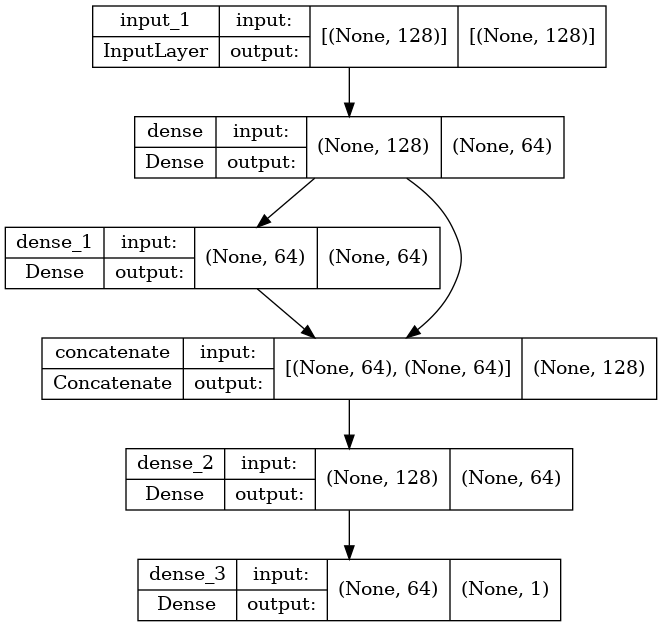

In [4]:
inp = L.Input((128,))
layer1 = L.Dense(64, activation='relu')(inp)
layer2 = L.Dense(64, activation='relu')(layer1)
concat = L.Concatenate()([layer1, layer2])
layer3 = L.Dense(64, activation='relu')(concat)
output = L.Dense(1, activation='sigmoid')(layer3)
model = keras.models.Model(inputs=inp,
                           outputs=output)
plot_model(model, show_shapes=True)

Residual-connection-making function.

In [5]:
def make_rc(split_layer, joining_head,
            merge_method='concat'):
    method_dic = {'concat':L.Concatenate(),
                  'add':L.Add(),
                  'avg':L.Average(),
                  'max':L.Maximum()}
    merge = method_dic[merge_method]
    conn_output = merge([split_layer, joining_head])
    return conn_output

Using automated method of making residual connections.

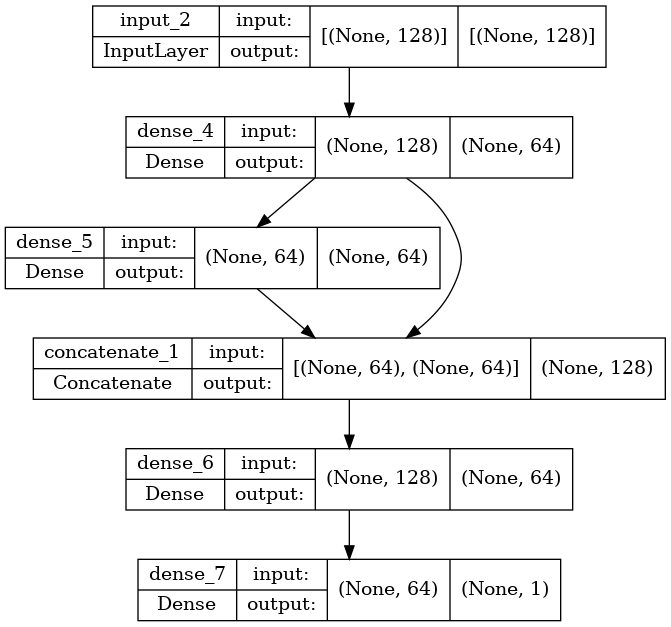

In [6]:
inp = L.Input((128,))
layer1 = L.Dense(64)(inp)
layer2 = L.Dense(64)(layer1)
layer3 = L.Dense(64)(make_rc(layer1, layer2))
output = L.Dense(1)(layer3)
model = keras.models.Model(inputs=inp,
                           outputs=output)
plot_model(model, show_shapes=True)

ResNet-style residual connections.

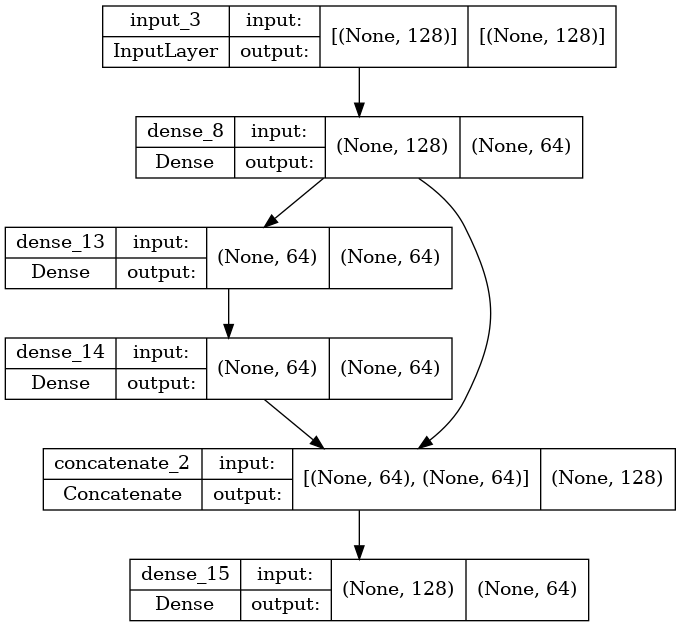

In [7]:
# number of residual connections
num_rcs = 3

# define input + first dense layer
inp = L.Input((128,))
x = L.Dense(64)(inp)

# create residual connections
for i in range(num_rcs):
    
    # build two layers to skip over
    x1 = L.Dense(64)(x)
    x2 = L.Dense(64)(x1)
    
    # define x as merging of x and x2
x = L.Dense(64)(make_rc(x,x2))

model = keras.models.Model(inputs=inp,
                           outputs=x)
plot_model(model, show_shapes=True)

DenseNet-style residual connections.

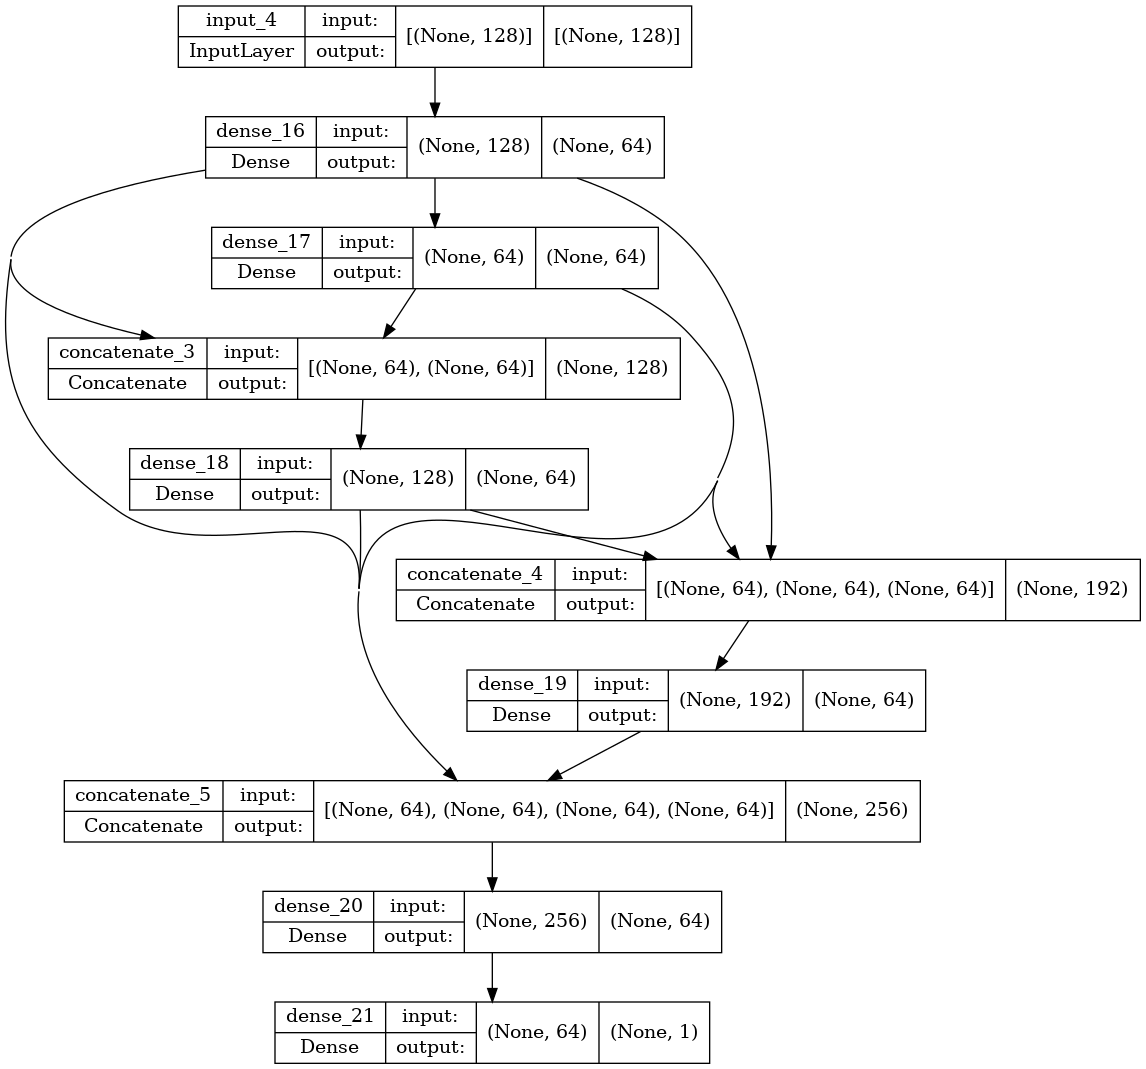

In [8]:
def make_rc(join_layers=[],
            merge_method='concat'):
    if len(join_layers) == 1:
        return join_layers[0]

    method_dic = {'concat':L.Concatenate(),
                  'add':L.Add(),
                  'avg':L.Average(),
                  'max':L.Maximum()}
    merge = method_dic[merge_method]
    conn_output = merge(join_layers)
    return conn_output

# define number of Dense layers
num_layers = 5

# create input layer
inp = L.Input((128,))
x = L.Dense(64, activation='relu')(inp)

# set layers list
layers = [x]

# loop through remaining layers
for i in range(num_layers-1):
    
    # define new layer
    x = L.Dense(64)(make_rc(layers))
    
    # add layer to list of layers
    layers.append(x)

# add output
output = L.Dense(1, activation='sigmoid')(x)

# build model
model = keras.models.Model(inputs=inp,
                           outputs=output)
plot_model(model, show_shapes=True)

### **Branching and Cardinality**

Manual definition of parallel branches.

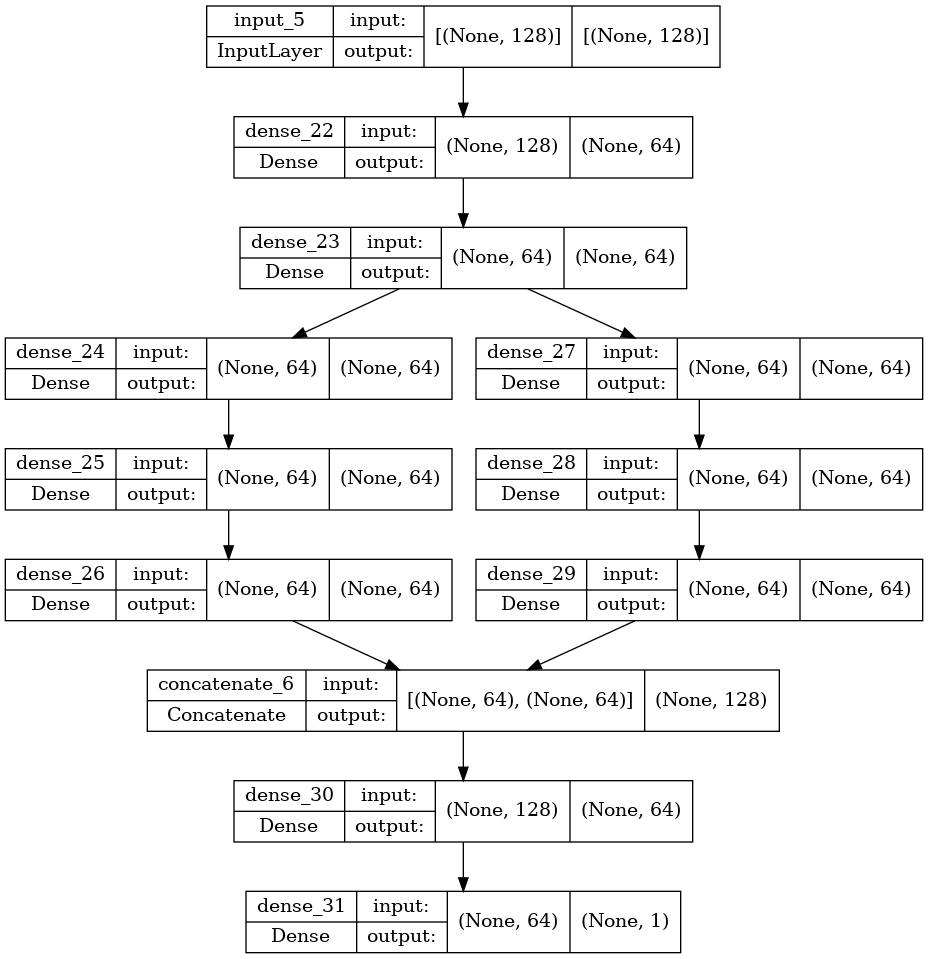

In [9]:
inp = L.Input((128,))
layer1 = L.Dense(64)(inp)
layer2 = L.Dense(64)(layer1)

branch1a = L.Dense(64)(layer2)
branch1b = L.Dense(64)(branch1a)
branch1c = L.Dense(64)(branch1b)

branch2a = L.Dense(64)(layer2)
branch2b = L.Dense(64)(branch2a)
branch2c = L.Dense(64)(branch2b)

concat = L.Concatenate()([branch1c, branch2c])
layer3 = L.Dense(64, activation='relu')(concat)
output = L.Dense(1, activation='sigmoid')(layer3)

model = keras.models.Model(inputs=inp,
                           outputs=output)
plot_model(model, show_shapes=True)

Automating the building of parallel branches.

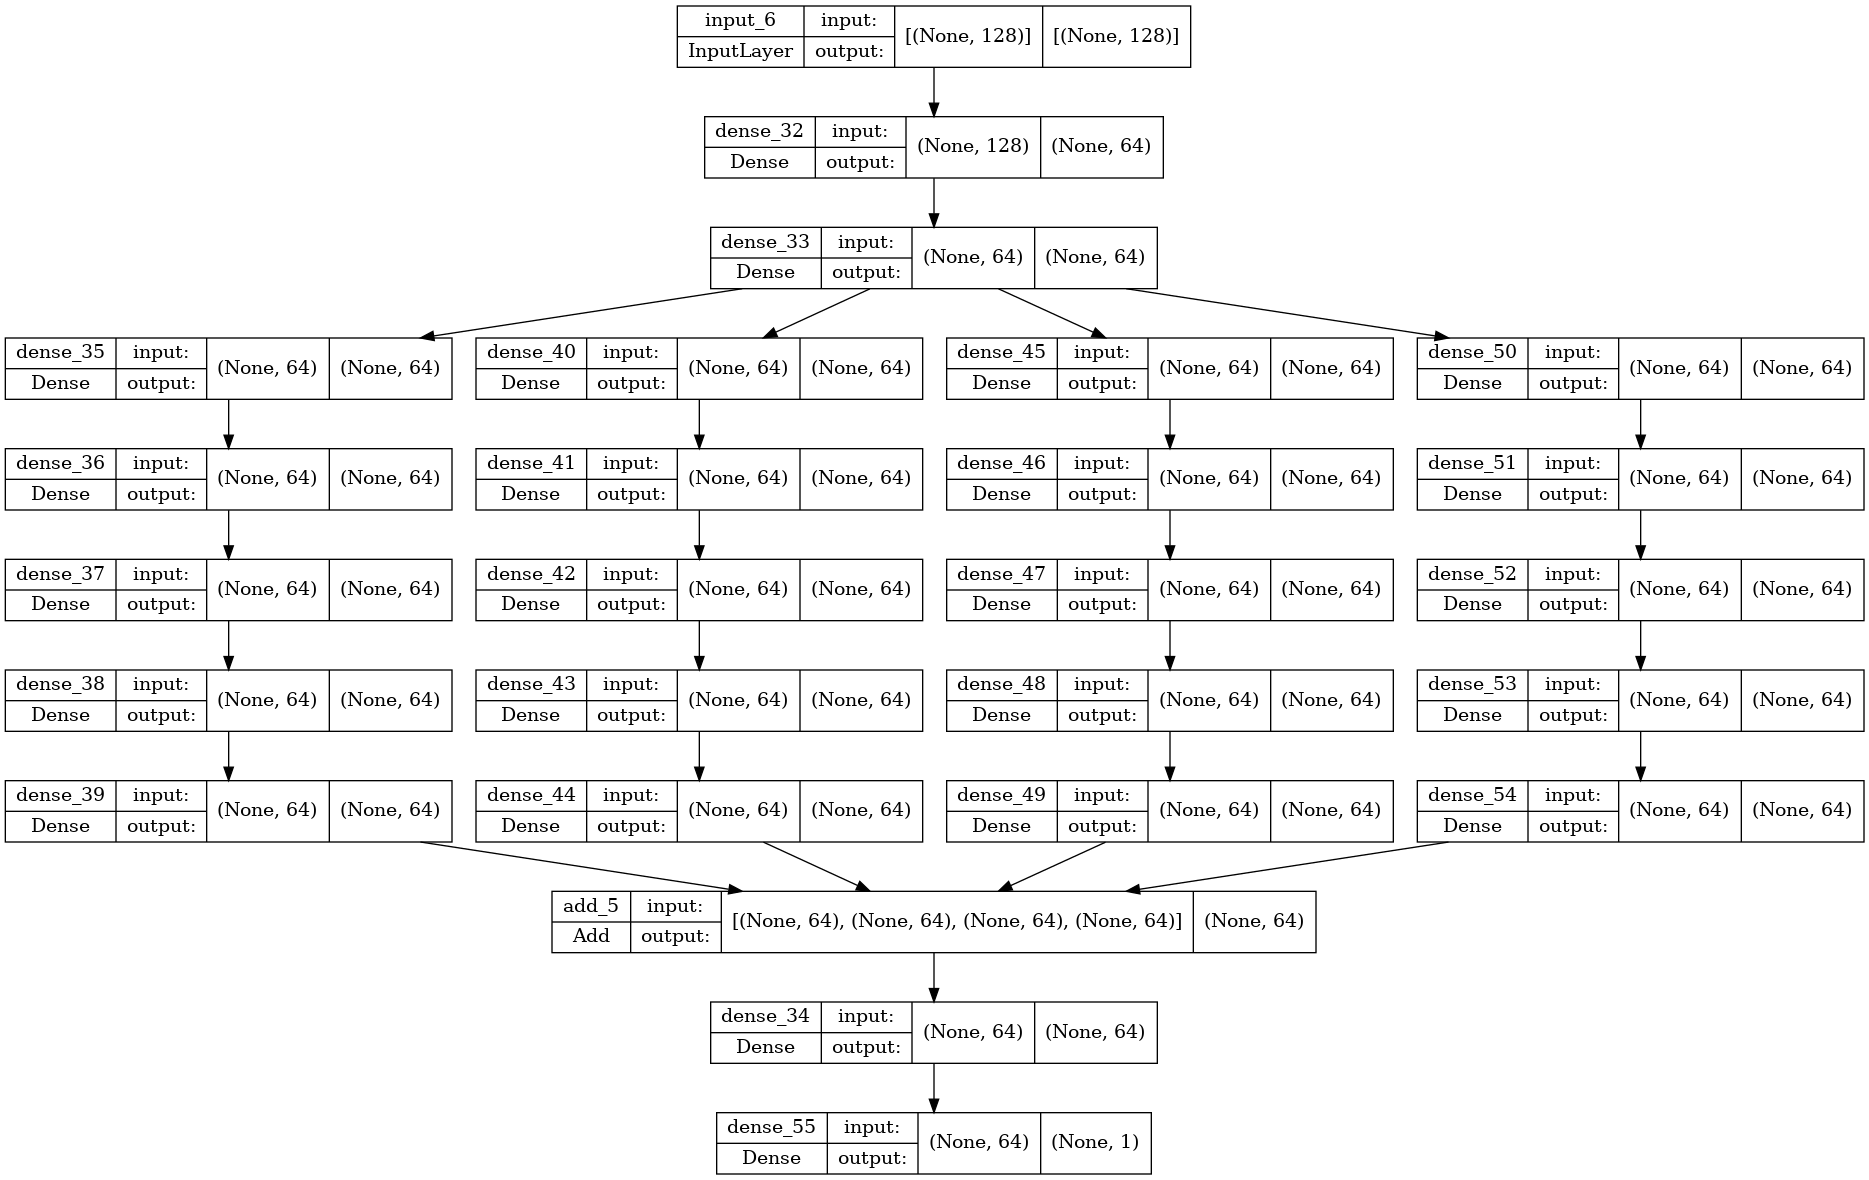

In [10]:
def build_branch(inp_layer,
                 num_layers=5):
    x = L.Dense(64)(inp_layer)
    for i in range(num_layers-1):
        x = L.Dense(64)(x)
    return x

def build_branches(splitting_head,
                   cardinality=4):
    outputs = []
    
    for i in range(cardinality):
        branch_output = build_branch(splitting_head)
        outputs.append(branch_output)
        
    merge = L.Add()(outputs)
    return merge

inp = L.Input((128,))
layer1 = L.Dense(64)(inp)
layer2 = L.Dense(64)(layer1)
layer3 = L.Dense(64)(build_branches(layer2))
output = L.Dense(1)(layer3)
model = keras.models.Model(inputs=inp,
                           outputs=output)
plot_model(model, show_shapes=True)

### **U-Net Architecture**

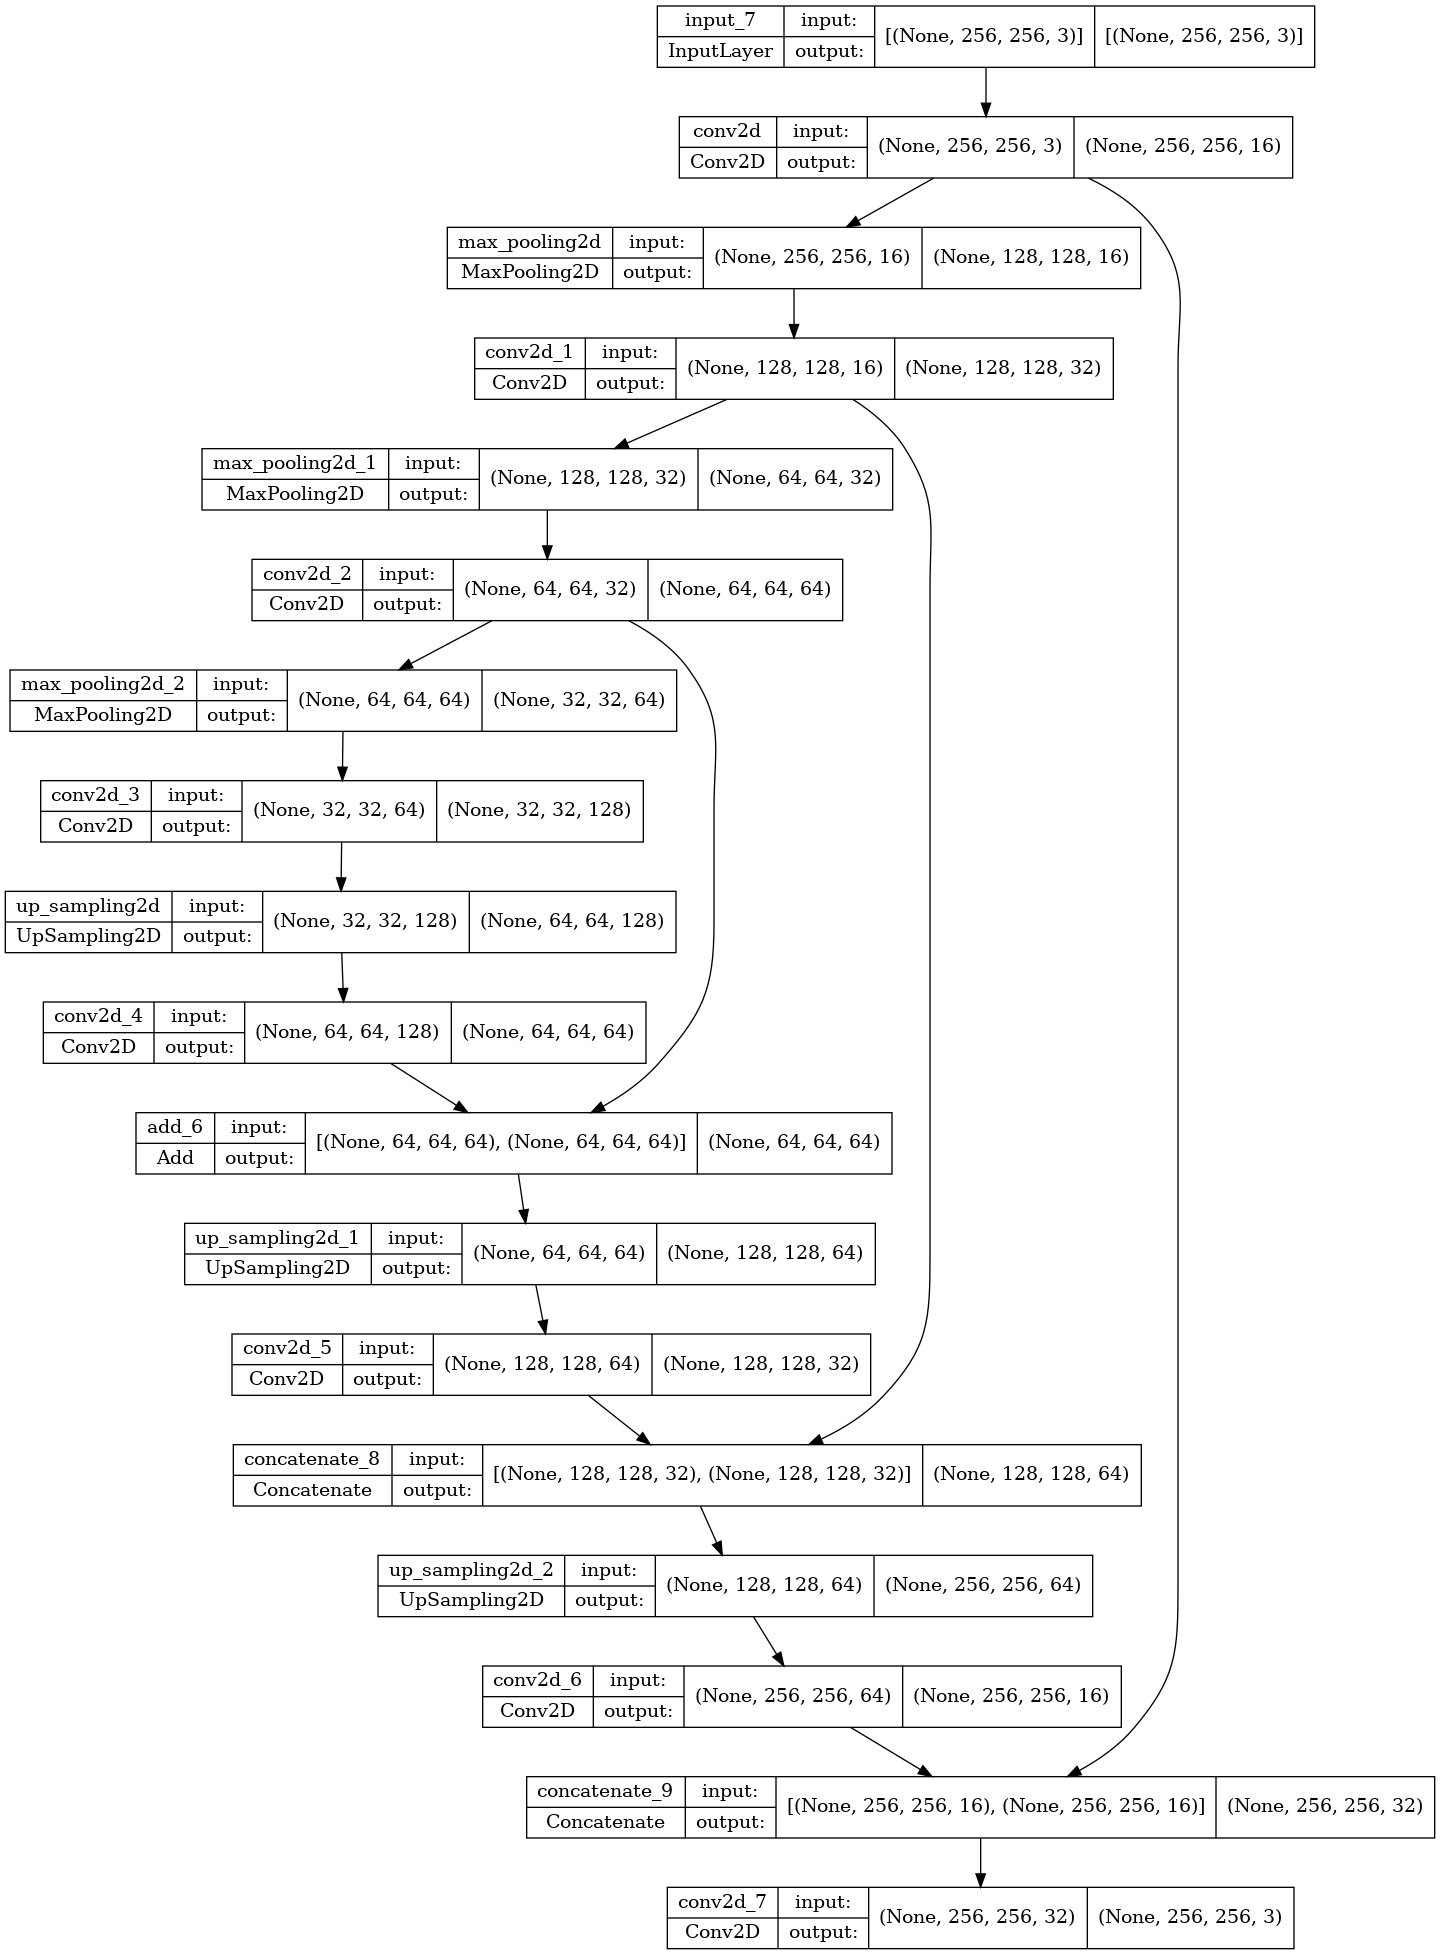

In [11]:
# input
inp = L.Input((256,256,3))

# contracting path
conv1 = L.Conv2D(16, (3,3), padding='same')(inp)
pool1 = L.MaxPooling2D((2,2))(conv1)

conv2 = L.Conv2D(32, (3,3), padding='same')(pool1)
pool2 = L.MaxPooling2D((2,2))(conv2)

conv3 = L.Conv2D(64, (3,3), padding='same')(pool2)
pool3 = L.MaxPooling2D((2,2))(conv3)

conv4 = L.Conv2D(128, (3,3), padding='same')(pool3)

# expanding path
upsamp4 = L.UpSampling2D((2,2))(conv4)
upsamp4 = L.Conv2D(64, (3,3), padding='same')(upsamp4)
merge3 = make_rc([conv3, upsamp4], merge_method='add')

upsamp3 = L.UpSampling2D((2,2))(merge3)
upsamp3 = L.Conv2D(32, (3,3), padding='same')(upsamp3)
merge2 = make_rc([conv2, upsamp3])

upsamp2 = L.UpSampling2D((2,2))(merge2)
upsamp2 = L.Conv2D(16, (3,3), padding='same')(upsamp2)
merge1 = make_rc([conv1, upsamp2])

# output
out = L.Conv2D(3, (1,1))(merge1)

# agg. into model
model = keras.models.Model(inputs=inp,
                           outputs=out)
plot_model(model, show_shapes=True)

## **Block/Cell Design**

### **Sequential Cell Design**

Building + stacking a static Dense cell.

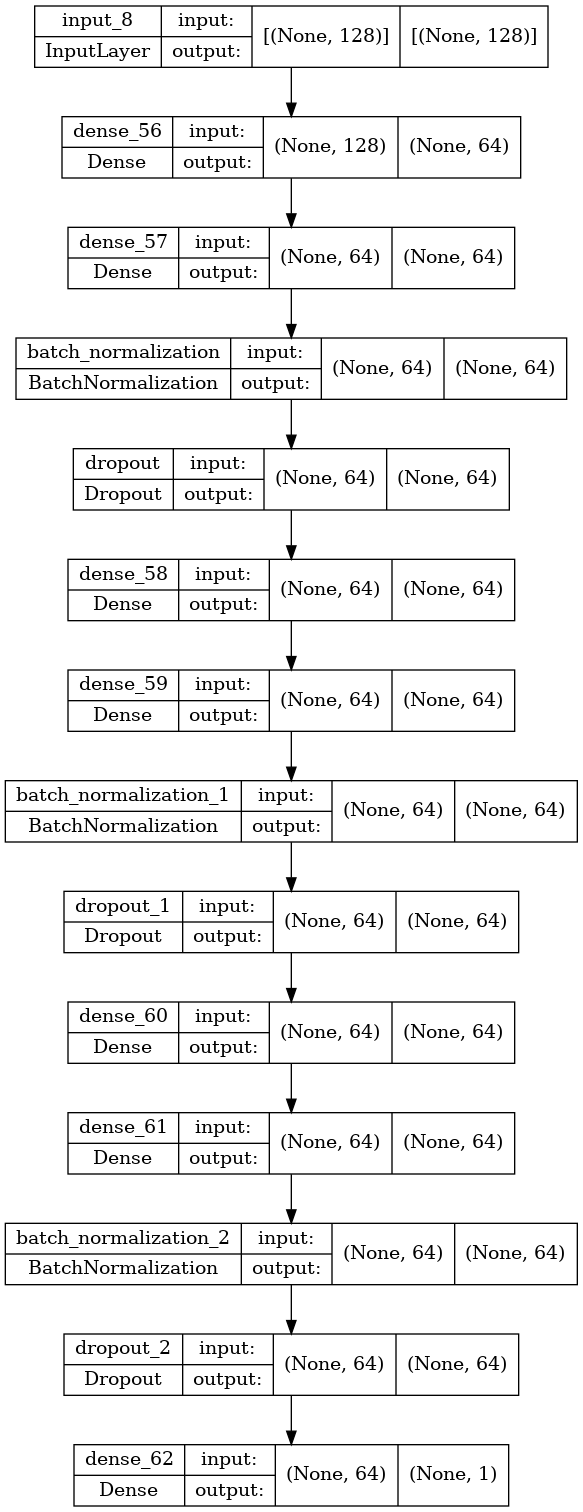

In [12]:
def build_static_dense_cell(inp_layer):
    dense_1 = L.Dense(64)(inp_layer)
    dense_2 = L.Dense(64)(dense_1)
    batchnorm = L.BatchNormalization()(dense_2)
    dropout = L.Dropout(0.1)(batchnorm)
    return dropout

num_cells = 3

inp = L.Input((128,))
x = build_static_dense_cell(inp)
for i in range(num_cells-1):
    x = build_static_dense_cell(x)
output = L.Dense(1, activation='sigmoid')(x)

model = keras.models.Model(inputs=inp,
                           outputs=output)
plot_model(model, show_shapes=True)

Building + stacking a static convolutional cell.

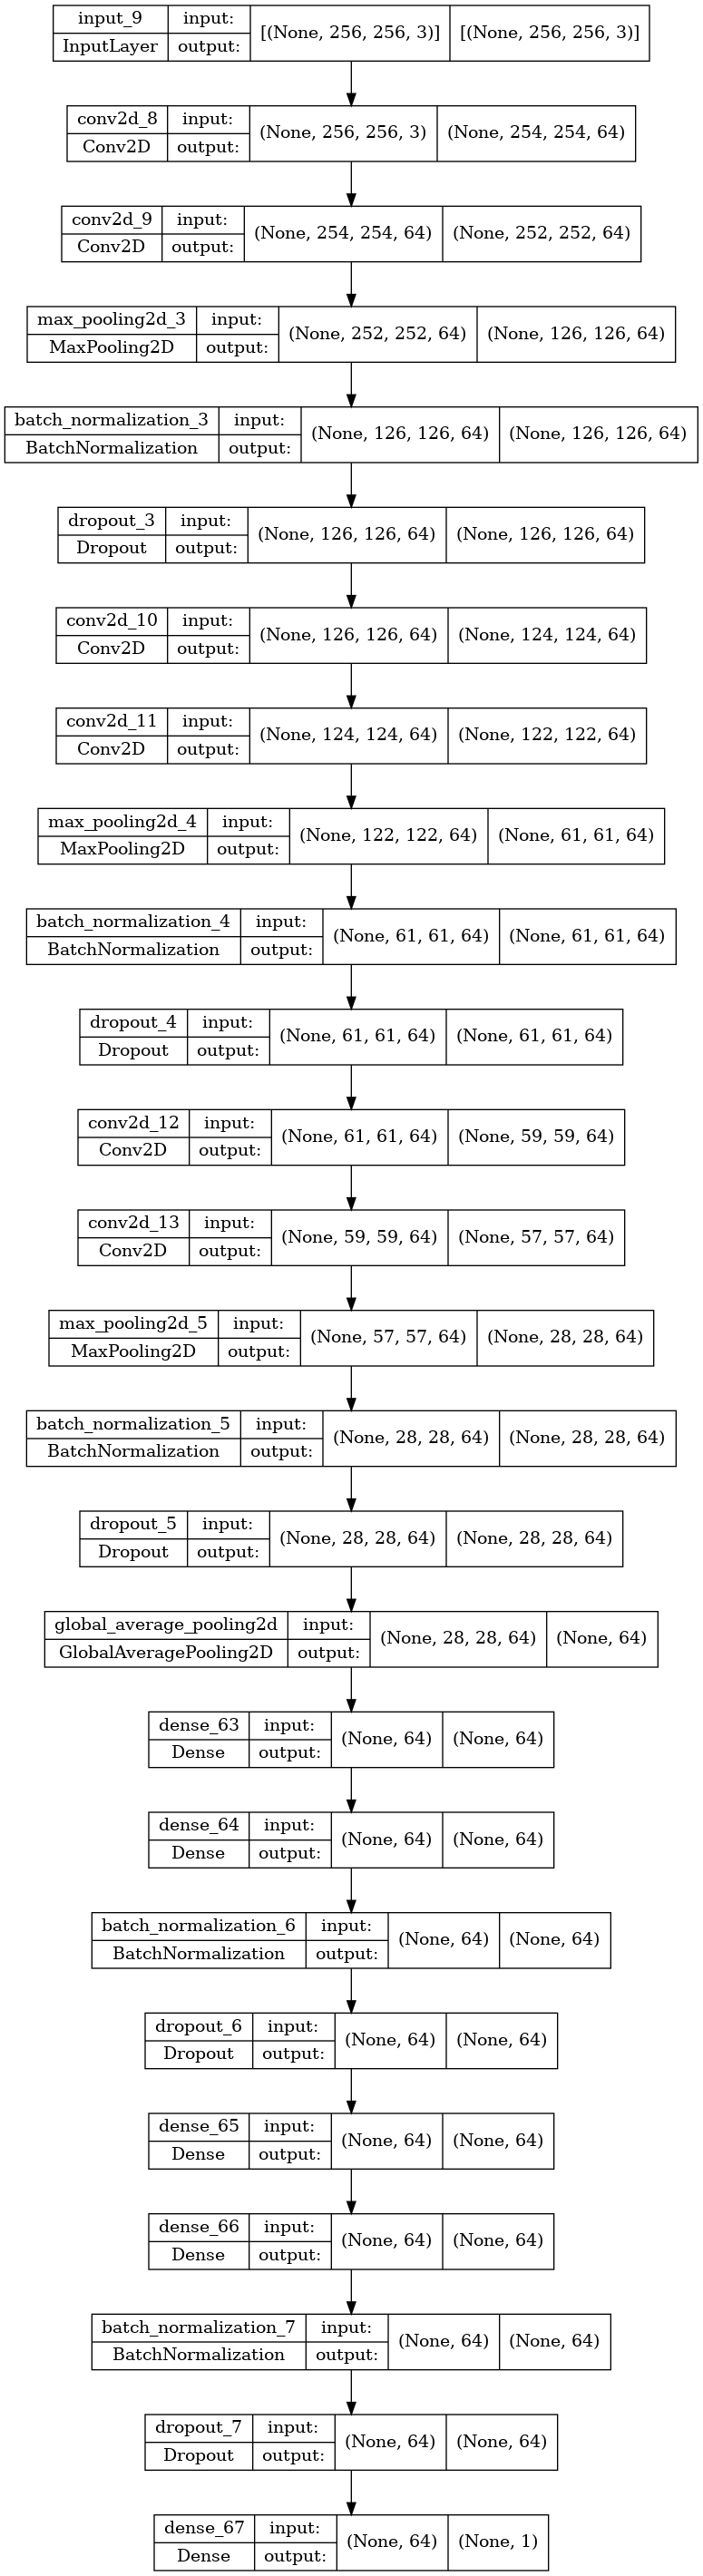

In [13]:
def build_static_conv_cell(inp_layer):
    conv_1 = L.Conv2D(64,(3,3))(inp_layer)
    conv_2 = L.Conv2D(64,(3,3))(conv_1)
    pool = L.MaxPooling2D((2,2))(conv_2)
    batchnorm = L.BatchNormalization()(pool)
    dropout = L.Dropout(0.1)(batchnorm)
    return dropout

num_conv_cells = 3
num_dense_cells = 2

inp = L.Input((256,256,3))
conv_cell = build_static_conv_cell(inp)
for i in range(num_conv_cells-1):
    conv_cell = build_static_conv_cell(conv_cell)
collapse = L.GlobalAveragePooling2D()(conv_cell)
dense_cell = build_static_dense_cell(collapse)
for i in range(num_dense_cells-1):
    dense_cell = build_static_dense_cell(dense_cell)
output = L.Dense(1, activation='sigmoid')(dense_cell)

model = keras.models.Model(inputs=inp,
                           outputs=output)
plot_model(model, show_shapes=True)

Building + stacking Dense normal and reduction cells.

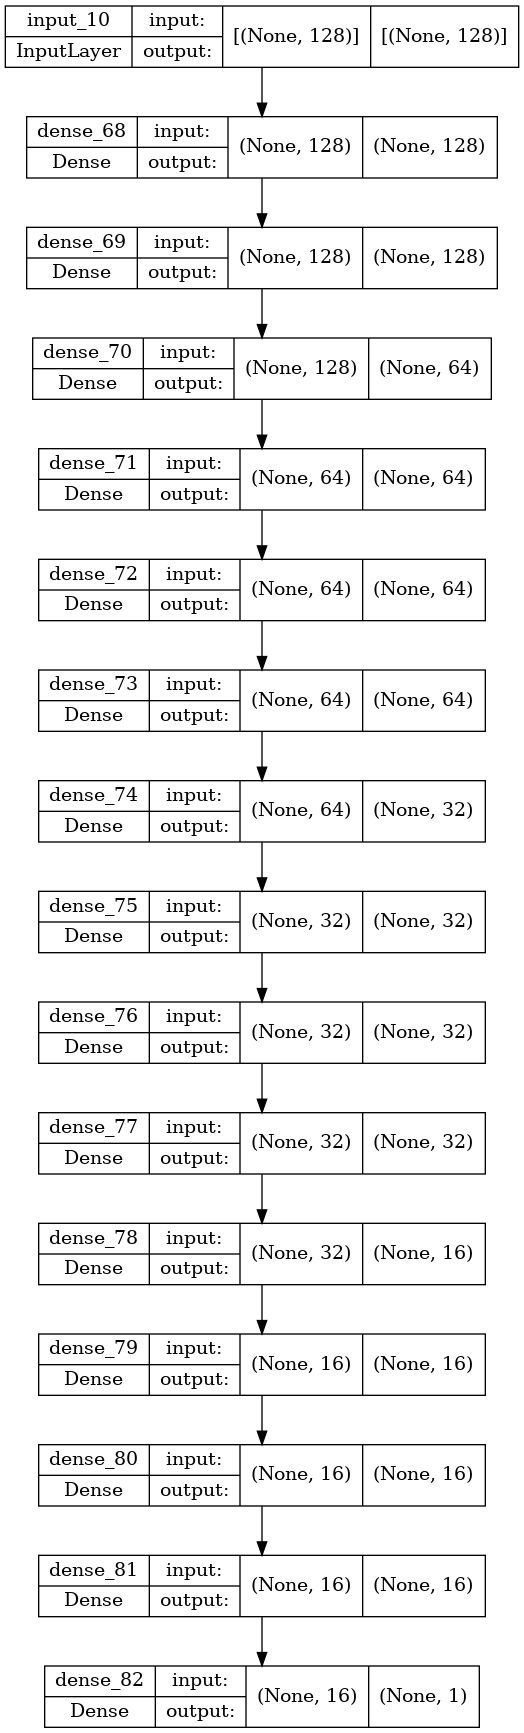

In [14]:
def build_normal_cell(inp_layer, width):
    dense_1 = L.Dense(width)(inp_layer)
    dense_2 = L.Dense(width)(dense_1)
    return dense_2, width

def build_reduce_cell(inp_layer, width):
    new_width = round(width/2)
    dense_1 = L.Dense(new_width)(inp_layer)
    dense_2 = L.Dense(new_width)(dense_1)
    return dense_2, new_width

num_repeats = 3

w = 128
inp = L.Input((w,))
cell_out, w = build_normal_cell(inp, w)
for repeat in range(num_repeats):
    cell_out, w = build_reduce_cell(cell_out, w)
    cell_out, w = build_normal_cell(cell_out, w)
output = L.Dense(1, activation='sigmoid')(cell_out)

model = keras.models.Model(inputs=inp,
                           outputs=output)
plot_model(model, show_shapes=True)

Building + stacking convolutional normal and reduction cells.

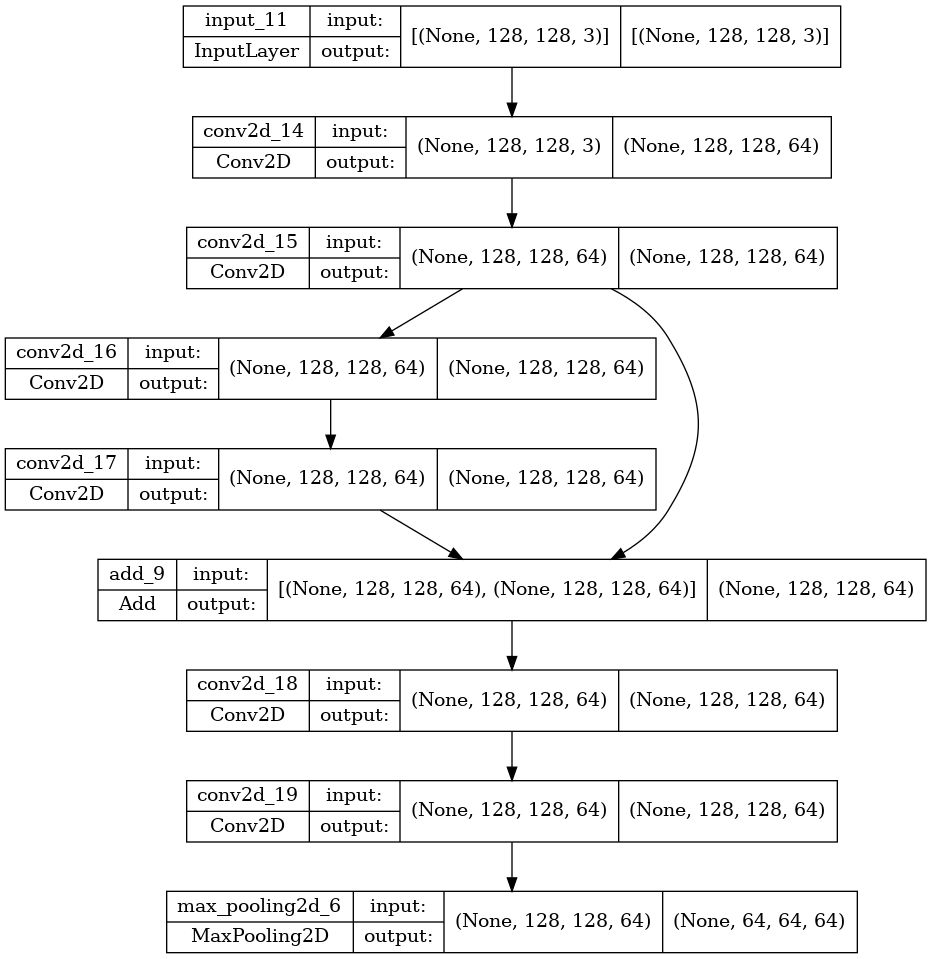

In [15]:
def build_normal_cell(inp_layer, shape):
    
    h,w,d = shape
    
    conv_1 = L.Conv2D(d,(3,3),padding='same')(inp_layer)
    conv_2 = L.Conv2D(d,(3,3),padding='same')(conv_1)
    
    return conv_2, shape

def build_reduce_cell(inp_layer, shape): 
    
    h,w,d = shape
    
    conv_1 = L.Conv2D(d,(3,3),padding='same')(inp_layer)
    conv_2 = L.Conv2D(d,(3,3),padding='same')(conv_1)
    pool = L.MaxPooling2D((2,2))(conv_2)
    
    new_shape = (np.ceil(h/2),np.ceil(w/2),d)
    return pool, new_shape

# nonlinear stacking method by building residual connections
inp = L.Input((128,128,3))
shape = (128,128,64)
norm_1, shape = build_normal_cell(inp, shape)
norm_2, shape = build_normal_cell(norm_1, shape)
merged = make_rc([norm_1,norm_2],merge_method='add')
reduce1, shape = build_reduce_cell(merged, shape)
model = keras.models.Model(inputs=inp,
                           outputs=reduce1)
plot_model(model, show_shapes=True)

### **Nonlinear Cell Design**

Normal convolutional cell design using nonlinear architecture (parallel branches).

In [16]:
def build_normal_cell(inp_layer, shape):
    
    h,w,d = shape
    
    branch1a = L.Conv2D(d,(5,5),padding='same')(inp_layer)
    branch1b = L.Conv2D(d,(3,3),padding='same')(branch1a)
    branch1c = L.Conv2D(d,(1,1))(branch1b)
    
    branch2a = L.Conv2D(d,(3,3),padding='same')(inp_layer)
    branch2b = L.Conv2D(d,(3,3),padding='same')(branch2a)
    
    branch3a = L.Conv2D(d,(3,3),padding='same')(inp_layer)
    branch3b = L.Conv2D(d,(1,1))(branch3a)
    
    merge = L.Concatenate()([branch1c, branch2b, branch3b])
    out = L.Conv2D(d, (1,1))(merge)
    
    return out, shape

Reduction convolutional cell design using nonlinear archtiecture (parallel branches).

In [17]:
def build_reduction_cell(inp_layer, shape):
    
    h,w,d = shape
    
    branch1a = L.Conv2D(d,(3,3), strides=(2,2),            
                        padding='same')(inp_layer)
    branch1b = L.Conv2D(d,(1,1))(branch1a)
    
    branch2a = L.MaxPooling2D((2,2),padding='same')(inp_layer)
    branch2b = L.Conv2D(d,(1,1))(branch2a)
    
    merge = L.Concatenate()([branch1b, branch2b])
    out = L.Conv2D(d*2, (1,1))(merge)
    
    new_shape = (np.ceil(h/2), np.ceil(w/2), d*2)
    return out, new_shape

### **Inceptionv3 Architecture Exploration**

Example implementation of Inceptionv3 module A.

In [18]:
def build_iv3_module_a(inp, shape):
    
    w, h, d = shape
    
    branch1a = L.Conv2D(d, (1,1))(inp)
    branch1b = L.Conv2D(d, (3,3), padding='same')(branch1a)
    branch1c = L.Conv2D(d, (3,3), padding='same')(branch1b)
    
    branch2a = L.Conv2D(d, (1,1))(inp)
    branch2b = L.Conv2D(d, (3,3), padding='same')(branch2a)
    
    branch3a = L.MaxPooling2D((2,2), strides=(1, 1),
                              padding='same')(inp)
    branch3b = L.Conv2D(d, (1,1), padding='same')(branch3a)
    
    branch4a = L.Conv2D(d, (1,1))(inp)
    
    concat = L.Concatenate()([branch1c, branch2b, 
                              branch3b, branch4a])
    return concat, shape

## **Network Scaling**

### **Input Shape-Adaptable Design**

Arbitrary input size with resizing layer for simple adaptability to input shape.

In [22]:
inp = L.Input((None,None,3))
resize = L.experimental.preprocessing.Resizing(
    height=128, width=128
)(inp)
dense1 = L.Dense(64)(resize)

Recursive architectural policy based on input size and usage in network.

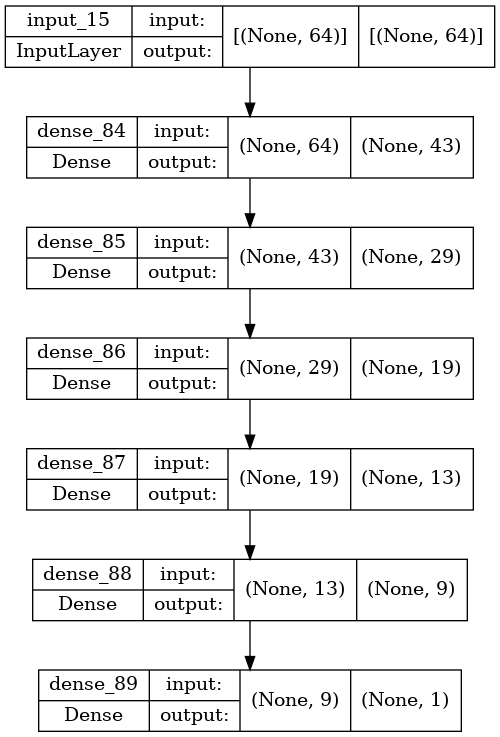

In [23]:
inp_width = 64
num_layers = 5

widths = [inp_width]
next_width = lambda w:round(w*2/3)
for i in range(num_layers): 
    widths.append(next_width(widths[-1]))

model = keras.models.Sequential()
model.add(L.Input((inp_width,)))
for i in range(num_layers):
    model.add(L.Dense(widths[i+1]))
model.add(L.Dense(1, activation='sigmoid'))

plot_model(model, show_shapes=True)

Architectural policy based on input size for convolutional data.

In [24]:
inp_shape = (128,128,3)
num_layers = 10

w, h, d = inp_shape
start_num_filters = 2**(round(np.log2(w))-4)
end_num_filters = 8*start_num_filters

filters = []
for i in range(num_layers):
    progress = i/num_layers
    if progress < 1/4:
        f = start_num_filters
    elif progress < 2/4:
        f = start_num_filters*2
    elif progress < 3/4:
        f = start_num_filters*4
    else:
        f = start_num_filters*8
    filters.append(f)

Convolutional autoencoder adaptable to various input sizes.

In [25]:
def encoder_cell(inp_layer, filters):
    x = L.Conv2D(filters, (3,3), padding='same')(inp_layer)
    x = L.Conv2D(filters, (3,3), padding='same')(x)
    x = L.MaxPooling2D((2,2))(x)
    return x

def decoder_cell(inp_layer, filters):
    x = L.UpSampling2D((2,2))(inp_layer)
    x = L.Conv2DTranspose(filters, (3,3), padding='same')(x)
    x = L.Conv2DTranspose(filters, (3,3), padding='same')(x)
    return x

i = 4
w, h, d = (256,256,3)
curr_shape = np.array([w, h])

inp = L.Input((w,h,d))

x = encoder_cell(inp, 2**i)
curr_shape = curr_shape/2
i += 1

# build encoder
while True:
    x = encoder_cell(x, 2**i)
    curr_shape = curr_shape/2
    if curr_shape[0] <= 16: break
    i += 1

# build decoder
while True:
    x = decoder_cell(x, 2**i)
    if i == 4: break
    i -= 1

# agg. into model
ae = keras.models.Model(inputs=inp, outputs=x)

### **Parametrization of Network Dimensions**

Example default/standard model to be parametrized.

In [26]:
model = keras.models.Sequential()
model.add(L.Input(64,))
model.add(L.Dense(32, activation='relu'))
model.add(L.Dense(32, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dense(16, activation='relu'))
model.add(L.Dense(16, activation='relu'))
model.add(L.Dense(1, activation='sigmoid'))

Parametrizing scalable model width.

In [27]:
width_coef = 1.0
w = lambda width: round(width*width_coef)

model = keras.models.Sequential()
model.add(L.Input(64,))
model.add(L.Dense(w(32), activation='relu'))
model.add(L.Dense(w(32), activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dense(w(16), activation='relu'))
model.add(L.Dense(w(16), activation='relu'))
model.add(L.Dense(1, activation='sigmoid'))

Parametrizing scalable model depth.

In [28]:
depth_coef = 1.0
d = lambda depth: round(depth*depth_coef)

model = keras.models.Sequential()
model.add(L.Input(64,))
for i in range(d(2)):
    model.add(L.Dense(w(32), activation='relu'))
model.add(L.BatchNormalization())
for i in range(d(2)):
    model.add(L.Dense(w(16), activation='relu'))
model.add(L.Dense(1, activation='sigmoid'))

Parametrizing nonlinear architectures (DenseNet-style residual connections) via scaling the linear backbone.

In [29]:
num_layers = d(5)

inp = L.Input((128,))
x = L.Dense(64, activation='relu')(inp)
layers = [x]
for i in range(num_layers-1):
    x = L.Dense(w(64))(make_rc(layers))
    layers.append(x)
output = L.Dense(1, activation='sigmoid')(x)
model = keras.models.Model(inputs=inp,
                           outputs=output)

### **EfficientNet**

Full code walk-through is [here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/efficientnet.py).

Key `round_filters` and `round_repeats` functions used in the EfficientNet implementation.

In [30]:
depth_divisor = 8
width_coefficient = 1.0
depth_coefficient = 1.0

def round_filters(filters, divisor=depth_divisor):
    filters *= width_coefficient
    new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:
        new_filters += divisor
    return int(new_filters)

def round_repeats(repeats):
    return int(math.ceil(depth_coefficient * repeats))